# Integration of SVM and MVO 

This notebook performs a comparison of the integrated MVO-SVM min variance portfolios obtained via the exact MIP solve vs the ADM method


In [ ]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
import math
import time
drive.mount('/content/gdrive')
pth = 'gdrive/My Drive/Colab Notebooks/'
import sys
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
#from svm_mvo import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')
wrds_svm_pca = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_PCA.pkl')
wrds_svm_pca['Momentum'] = wrds_svm.Momentum
## Import Monthly Prices
prices = pd.read_pickle(pth + 'SVM MVO/DATA/PRICES.pkl')

     |████████████████████████████████| 11.1 MB 5.1 MB/s 
Mounted at /content/gdrive


In [ ]:
#read in licence info
gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
print("Required info for Gurobi:", gurobi_licence.columns)
try:
  #web license try to access it via uoft
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey {gurobi_licence.LOCAL[0]}
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()


Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET

--------------------------------------------
--------------------------------------------

info  : grbgetkey version 9.1.2, build v9.1.1rc0-30-g8af970cb
info  : Contacting Gurobi license server...
info  : License file for license ID 726787 was successfully retrieved
info  : License expires at the end of the day on 2022-01-13
info  : Saving license file...

In which directory would you like to store the Gurobi license file?
[hit Enter to store it in /opt/gurobi]: 

A license file already exists in '/opt/gurobi/gurobi.lic'
Continue? [Y/n] 

info  : License 726787 written to file /opt/gurobi/gurobi.lic

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         226G   43G  184G  19% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  817M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1       233G   45G  188G  20% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  5.1G   10G  34% /content/gdrive


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:         9629080 kB
MemAvailable:   12010132 kB
Buffers:          186000 kB
Cached:          2036924 kB
SwapCached:            0 kB
Active:          1454048 kB
Inactive:        1980128 kB
Active(anon):     880488 kB
Inactive(anon):      492 kB
Active(file):     573560 kB
Inactive(file):  1979636 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               864 kB
Writeback:             0 kB
AnonPages:       1211132 kB
Mapped:           325784 kB
Shmem:              1180 kB
KReclaimable:     138664 kB
Slab:             182440 kB
SReclaimable:     138664 kB
SUnreclaim:        43776 kB
KernelStack:        5808 kB
PageTables:         8964 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    4657504 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        8292 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
%run /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/PYFILES/svm_mvo.py

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET

--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


In [ ]:
mth = rets.index[25]
mth

Timestamp('2002-08-01 00:00:00')

In [ ]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Momentum"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
#Y_ = Y_[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
cols = ['LEV1', 'GRW1', 'Momentum']
Y_ = Y_[cols]
#Y_['momentum'] = mean
AssetLim = math.floor(N*0.8)

ret_constr = -1
soft_margin = 5000

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

### ADM method with individual updates on the penalty parameters

In [ ]:
MVO_2 = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_2 = SVM(tics, Y_ , soft_margin*np.ones_like(mean))

SVM_MVO_Fast_v2 = SVM_MVO_ADM_v2(MVO_2, SVM_2, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast_v2.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast_v2.SVM_.model.params.timelimit = 60
SVM_MVO_Fast_v2.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast_v2.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast_v2.initialize_soln()
ws_2, xs_2, zs_2 , xi_mvo_2, xi_svm_2, dt_2, objs_svm_2, objs_mvo_2 = SVM_MVO_Fast_v2.solve_ADM()
end = time.time()
print("Solution time", end - start)

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET

--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic
Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Stalling at Infeasible Point
SVM  0.2860000729192267
MVO  0.2860000000049321
Stalling at Infeasible Point
SVM  0.00023102919008582764
MVO  0.00023102643849719478
ADM terminated with average value of C =  1787.2314453125
Solution time 48.10679292678833


<Figure size 432x288 with 0 Axes>

In [ ]:
xi_svm_2.sum(axis =1)[np.argmin(xi_svm_2.sum(axis =1))]

9.728042844571274e-11

0.0

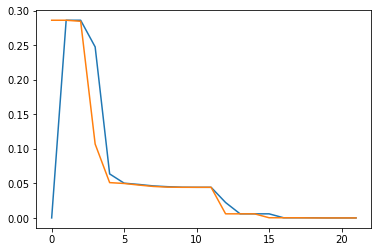

In [ ]:
#plt.plot(ws[:,1])
np.abs(SVM_MVO_Fast_v2.SVM_.w.x).sum()*10**(-3)
plt.plot(xi_mvo_2.sum(axis=1))

plt.plot(xi_svm_2.sum(axis=1))

#plt.plot(objs_svm_2)

SVM_MVO_Fast_v2.MVO_.xi.x.sum()

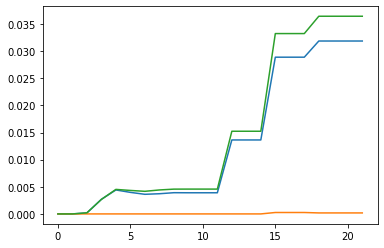

In [ ]:
plt.plot(ws_2)

### Mean Variance and SVM Joint Using Alternating Directions Method Class Definition

In [ ]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_ = SVM(tics, Y_ , soft_margin)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast.initialize_soln()
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo = SVM_MVO_Fast.solve_ADM()
end = time.time()
print("Solution time", end - start)


Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter timelimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
ADM terminated with C =  23.218660767764817
Solution time 16.635645389556885


##Exact MIP Solution 

In [ ]:
#SVM with slack 
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim, \
                      svm_choice = (True, True), print_var_frntr = False, indicator = False)
# starts = [SVM_MVO_Fast.x.x, SVM_MVO_Fast.z.x, SVM_MVO_Fast.w.x, SVM_MVO_Fast.b.x]
# SVM_MVO_Slck.set_model(start = starts)
# # SVM_MVO_Slck.model.params.Presolve = 2
# # SVM_MVO_Slck.model.Params.ImpliedCuts = 2
# SVM_MVO_Slck.optimize()

In [ ]:
SVM_MVO_Slck.model.reset(clearall = 1)
SVM_MVO_Slck.set_model()
SVM_MVO_Slck.optimize()

Discarded solution information including additional information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 861 rows, 1148 columns and 4862 nonzeros
Model fingerprint: 0x3ec572ea
Model has 41044 quadratic objective terms
Variable types: 862 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [4e-05, 1e+02]
  Objective range  [7e+00, 7e+00]
  QObjective range [2e-06, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Found heuristic solution: objective 4.000000e+12
Presolve removed 1 rows and 286 columns
Presolve time: 0.02s
Presolved: 860 rows, 862 columns, 4576 nonzeros
Presolved model has 41044 quadratic objective terms
Variable types: 576 continuous, 286 integer (286 binary)

Root relaxation: objective 1.528317e-03, 616 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

92.59050607681274

## Comparison between exact and ADM method

In [ ]:
return_premium = -1 #(Min variance portfolio)
T = len(rets.index)

In [ ]:
import time
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 60s
    if time.time() - model._time > 60:
        model.terminate()

def evaluate_model(rets, forecasts, wrds_svm, return_premium, model_instance, T, N, cols):
  # lr = 0.1 #learning rate for the SVM support vector
  portfolio_weights = np.zeros([T,N])
  xi = np.zeros([T,N])
  z = np.zeros([T,N])

  oot_returns = np.zeros(T)
  risks = np.zeros(T)
  svm_margins = np.zeros(T)
  svm_penalties = np.zeros(T)

  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = np.zeros(T)
  
  times = np.zeros(T)
  i = 0 #index for dates
  w_mabs = 0 #initialize
  # soln_mods = {}

  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    if return_premium == -1:
      ret_constr = -1
    else:
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.tics = tics
    model_instance.ret_constr = ret_constr
    model_instance.mean_ret = mean
    model_instance.cov = cov
    model_instance.exogenous = Y_

    # if i > 0: #not the first trade gets a constraint on turnover
    #   x_prev = model_instance.x.X

    # if model_instance.svm_constr:
    #   w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.w.x).mean()
    #   w_prev = model_instance.w.x
    model_instance.model.reset(clearall = 1)
    model_instance.set_model()

    # if i > 0: #not the first trade gets a constraint on turnover
    #   model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

    # if model_instance.svm_constr:
    #   u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
    #   wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
    #   wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_instance.model.Params.LogToConsole = 0
    model_instance.model.setParam('TimeLimit', 500)
    start = time.time()
    model_instance.optimize()
    end = time.time()
    dt = end - start 
    print(dt)
    # k = 1
    # while model_instance.model.status == 4:
    #   #if the model is infeasible the decrease the return constraint
    #   #we do not have enough turnover the modify the portfolio to achive the 
    #   #return target... not a great place to be
    #   return_premium_temp = return_premium - 0.05*k
    #   ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
    #   model_instance.ret_constr = ret_constr
    #   model_instance.ret_target[0].rhs = ret_constr
    #   model_instance.optimize(cbb = cb)
    #   k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve


    # if model_instance.model.IsMIP:
    #   soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    # else:
    #   soln_mods[prd] = return_premium_temp
    
    oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    risks[i] = model_instance.portfolio_risk.getValue()[0]
    svm_margins[i] = model_instance.svm_margin.getValue()[0]
    svm_penalties[i] = model_instance.soft_penalty.getValue()[0]
    portfolio_weights[i, :] = model_instance.x.x
    xi[i,:] = model_instance.xi.x
    z[i,:] = model_instance.z.x
    times[i] = dt
    
  
    if model_instance.svm_constr:
      wis[i,:] = model_instance.w.x
      bias[i] = model_instance.b.x
    if i + 1 >= T:
      break
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
      objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                        , columns = rets.index[:T],
                                        index = ["Return", "Market", "Risk", 
                                                    "Margin", "Infeasibility", "Run-Time"])
      #eligible_weights = pd.DataFrame()
      portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
      xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_instance.tics)
      z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_instance.tics)

      svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
      svm_weights['bias'] = bias
      
      svm_results = (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)
      with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_exact_mvp_lrg_v3.pkl", 'wb') as fp:
        pkl.dump(svm_results, fp);
    i = i+1
  objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                    , columns = rets.index[:T],
                                    index = ["Return", "Market", "Risk", 
                                                "Margin", "Infeasibility", "Run-Time"])
  #eligible_weights = pd.DataFrame()
  portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
  xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_instance.tics)
  z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_instance.tics)

  svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
  svm_weights['bias'] = bias
  
  svm_results = (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)
  with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_exact_mvp_lrg_v3.pkl", 'wb') as fp:
    pkl.dump(svm_results, fp);
  return (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)


In [ ]:
svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols)

Discarded solution information including additional information
138.67680597305298
_________________________
Iteration  0
Percent Complete  0.0
53.17736053466797
196.88089990615845
170.22957515716553
59.552515745162964
31.010326862335205
181.98824906349182
299.31821298599243
182.98406624794006
128.541264295578
37.70572757720947
41.97007155418396
139.96403074264526
_________________________
Iteration  12
Percent Complete  0.04918032786885246
203.56630444526672
346.6328110694885
132.60552191734314
44.457436084747314
111.8472318649292
168.27757358551025
103.1965434551239
144.28107213974
268.73148345947266
32.45881485939026
101.65588188171387
65.65929126739502
_________________________
Iteration  24
Percent Complete  0.09836065573770492
88.35431146621704
69.66843914985657
18.616086721420288
143.3056037425995
181.45321607589722
32.30336380004883
86.98273730278015
37.48817586898804
47.8853964805603
103.94339561462402
29.91177535057068
108.83774209022522
_________________________
Iteration  3

In [ ]:
def evaluate_adm(rets, forecasts, wrds_svm, return_premium, model_instance, T, 
                 N, cols, link):
  # lr = 0.1 #learning rate for the SVM support vector
  portfolio_weights = np.zeros([T,N])
  xi = np.zeros([T,N])
  z = np.zeros([T,N])
  oot_returns = np.zeros(T)
  risks = np.zeros(T)
  svm_margins = np.zeros(T)
  svm_penalties = np.zeros(T)

  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = np.zeros(T)
  
  times = np.zeros(T)
  i = 0 #index for dates
  w_mabs = 0 #initialize
  # soln_mods = {}

  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    if return_premium == -1:
      ret_constr = -1
    else:
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.MVO_.tics = tics
    model_instance.SVM_.tics = tics
    model_instance.MVO_.ret_constr = ret_constr
    model_instance.MVO_.mean_ret = mean
    model_instance.MVO_.cov = cov
    model_instance.MVO_.exogenous = Y_
    model_instance.SVM_.exogenous = Y_
    # if i > 0: #not the first trade gets a constraint on turnover
    #   x_prev = model_instance.x.X

    # if model_instance.svm_constr:
    #   w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.w.x).mean()
    #   w_prev = model_instance.w.x
    # if i == 0:
    model_instance.SVM_.model.reset(clearall = 1)
    model_instance.MVO_.model.reset(clearall = 1)

    start = time.time()
    model_instance.initialize_soln()
    # else:
    #   start = time.time()

    # if i > 0: #not the first trade gets a constraint on turnover
    #   model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

    # if model_instance.svm_constr:
    #   u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
    #   wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
    #   wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_instance.silence_output()
    model_instance.solve_ADM(store_data=False)
    end = time.time()
    dt = end-start
    print(dt)
    # k = 1
    # while model_instance.model.status == 4:
    #   #if the model is infeasible the decrease the return constraint
    #   #we do not have enough turnover the modify the portfolio to achive the 
    #   #return target... not a great place to be
    #   return_premium_temp = return_premium - 0.05*k
    #   ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
    #   model_instance.ret_constr = ret_constr
    #   model_instance.ret_target[0].rhs = ret_constr
    #   model_instance.optimize(cbb = cb)
    #   k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve

    # if model_instance.model.IsMIP:
    #   soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    # else:
    #   soln_mods[prd] = return_premium_temp
    
    oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    portfolio_weights[i, :] = model_instance.x.x
    xi[i,:] = model_instance.SVM_.xi.x
    z[i,:] = model_instance.z.x
    risks[i] = model_instance.portfolio_risk.getValue()[0]
    svm_margins[i] = model_instance.svm_margin.getValue()[0]
    svm_penalties[i] = model_instance.soft_penalty.getValue()[0]
    portfolio_weights[i, :] = model_instance.x.x
    times[i] = dt
    wis[i,:] = model_instance.w.x
    bias[i] = model_instance.b.x

    if i + 1 >= T:
      break
      
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)  
      objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                       , columns = rets.index[:T],
                                       index = ["Return", "Market", "Risk", 
                                                  "Margin", "Infeasibility", "Run-Time"])
      #eligible_weights = pd.DataFrame()
      portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
      xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_instance.tics)
      z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_instance.tics)

      svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
      svm_weights['bias'] = bias
      adm_results = (portfolio_weights, objective_information.T, svm_weights, z_pd, xi_pd)
      with open(link, 'wb') as fp:
        pkl.dump(adm_results, fp);
    i = i+1 
  objective_information = pd.DataFrame([oot_returns, market, risks, svm_margins, svm_penalties,times]
                                  , columns = rets.index[:T],
                                  index = ["Return", "Market", "Risk", 
                                              "Margin", "Infeasibility", "Run-Time"])
  #eligible_weights = pd.DataFrame()
  portfolio_weights_pd = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
  xi_pd = pd.DataFrame(xi, index = rets.index[:T], columns = model_instance.tics)
  z_pd = pd.DataFrame(z, index = rets.index[:T], columns = model_instance.tics)

  svm_weights = pd.DataFrame(wis, index = rets.index[:T], columns = cols)
  svm_weights['bias'] = bias
  adm_results = (portfolio_weights, objective_information.T, svm_weights, z_pd, xi_pd)
  with open(link, 'wb') as fp:
    pkl.dump(adm_results, fp);
  return (portfolio_weights_pd, objective_information.T, svm_weights, z_pd, xi_pd)

In [ ]:
link = "gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_adm_mvp_lrg_v3.pkl"
adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, 
                           T, N, cols, link)

71.25002360343933
_________________________
Iteration  0
Percent Complete  0.0
61.88559079170227
69.46586084365845
63.42400026321411
71.95560312271118
68.8981683254242
34.26241159439087
86.07929539680481
62.953888177871704
65.95587158203125
66.48721647262573
72.98277544975281
84.8574104309082
_________________________
Iteration  12
Percent Complete  0.04918032786885246
65.47537422180176
64.31070041656494
64.72183012962341
64.19623637199402
79.17409801483154
76.22135758399963
76.16383242607117
76.27866792678833
81.60879564285278
83.24350166320801
66.07275581359863
62.53602480888367
_________________________
Iteration  24
Percent Complete  0.09836065573770492
ADM terminated with C =  23.218660767764817
15.095691204071045
66.64786458015442
64.53011679649353
68.56810140609741
74.46222686767578
69.29016613960266
90.12732100486755
ADM terminated with C =  1219.0136542044745
31.8314368724823
34.044559717178345
70.62366008758545
ADM terminated with C =  62.5
19.300486087799072
52.3503665924072

In [ ]:
link = "gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_adm2_mvp_lrg_random.pkl"
adm_results2 = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast_v2, 
                           T, N, cols, link)

Stalling at Infeasible Point
SVM  0.2801398026633376
MVO  0.2801376668338085
Stalling at Infeasible Point
SVM  0.0030024642805107395
MVO  0.003002464262062931
ADM terminated with average value of C =  2162.175105168269
69.58387875556946
_________________________
Iteration  0
Percent Complete  0.0
Stalling at Infeasible Point
SVM  0.28398695097056736
MVO  0.28398607184026314
Stalling at Infeasible Point
SVM  0.005485896430511252
MVO  0.00548586020644917
ADM terminated with average value of C =  1781.5504807692307
35.794209480285645
Stalling at Infeasible Point
SVM  0.28366339140674157
MVO  0.2836574188255033
Stalling at Infeasible Point
SVM  0.007492245267695964
MVO  0.007491495274178303
Stalling at Infeasible Point
SVM  0.0010145564463044591
MVO  0.0010145541060500992
ADM terminated with average value of C =  19659.5458984375
76.8131959438324
Stalling at Infeasible Point
SVM  0.28420813423999947
MVO  0.28420659925930336
Stalling at Infeasible Point
SVM  0.002176814723780305
MVO  0.0021